# Pyturbseq

`pyturbseq` is a tool for analysis of single cell functional genomics and perturbation data.

This tutorial describes the basic usage of Pyturbseq. It is assumed that the user has already installed Pyturbseq and its dependencies. If not, please refer to the installation instructions.


In [15]:
import scanpy as sc
import pyturbseq as ptrb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Single Cell QC

### read in cellranger 

Do this for each 10x lane

In [ ]:
from pyturbseq.utils import split_feature_type

In [3]:
cellranger_base_path = '/data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs'
gex_path = f'{cellranger_base_path}/filtered_feature_bc_matrix/'
print(gex_path)

/data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs/filtered_feature_bc_matrix/


In [32]:
adata = sc.read_10x_mtx(gex_path, gex_only=False) ## read in gene expression and sgRNA count information
adata.var_names_make_unique()
adata.obs_names_make_unique()

### Get guide calls from cellranger


cellranger provides sgRNA calls and analysis when running `cellranger count` with a feature library.

In [33]:
from pyturbseq.utils import get_CR_sgRNA_assignment, split_by_feature_type

/data_gilbert3/awinters/projects/DNMT1i/data/large_perturbseq/cellranger/gex_sgrna/hl60_1/outs/crispr_analysis/
Overlap with cbcs:
0.7505441880713974


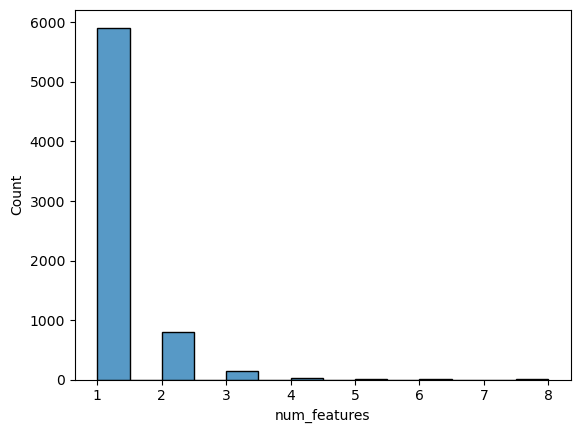

,num_features,feature_call,num_umis
TGTGAGTAGAAGTATC-1,1,ZRSR2_A,504
TTCATTGTCTCAACGA-1,1,ZRSR2_A,17
TTGAACGAGGCCCGTT-1,1,ZRSR2_A,54
CTCAACCCAAGGACAC-1,4,ZRSR2_A|DAXX_A|GATA4_A|CHD4_A,23|51|45|61
TGCATGAGTGGGTTGA-1,2,ZRSR2_A|UBAP2L_A,74|306


In [34]:
# cellranger_crispr_out = 'out = base_dir + GEX_dir + cellranger_id  + '/outs/crispr_analysis/''
crispr_out = f'{cellranger_base_path}/crispr_analysis/'
print(crispr_out)
#get CR sgRNA assignment for list of cell barcodes
calls = get_CR_sgRNA_assignment(
    adata.obs.index,
    crispr_out)
sns.histplot(calls['num_features'])
plt.show()
calls.tail()

In [36]:
#add custom annotation based on feature_call and num_features
calls['perturbation'] =  None ## confident guide assignment column

## assign guide to a cel=s ONLY if they have 1 guide called
calls.loc[calls['num_features'] == 1, 'perturbation'] = calls.loc[calls['num_features'] == 1, 'feature_call']

#custom formating the guide names
calls['guide'] = calls['perturbation']
calls['perturbation'] = calls['perturbation'].str.replace('NTC_[A-Z]', 'NTC', regex=True) #merge all the NTCs into one perturbation class
calls['perturbation'] = calls['perturbation'].str.replace('_', '-') #make it friendly with DEseq2
calls['target_gene']  = calls['guide'].str.split('_').str[0] #get a target gene for each. In this case is just the name of the guide
calls.loc[calls['perturbation'] == 'NTC', 'target_gene'] = None #set NTC target gene to None

## append guide call to adata
adata.obs = pd.concat([adata.obs, calls], axis=1) # fix problem adding multiple columns instead of overwriting
adata.obs.head()

,num_features,feature_call,num_umis,perturbation,guide,target_gene
AAACCCAAGCACGGAT-1,2.0,DCPS_A|CUL5_A,986|1635,None,None,None
AAACCCAAGGATACAT-1,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGGTAGACC-1,1.0,NTC_D,943,NTC,NTC_D,None
AAACCCACAGATACTC-1,1.0,ERCC6_A,777,ERCC6-A,ERCC6_A,ERCC6
AAACCCAGTCGTGGAA-1,NaN,NaN,NaN,NaN,NaN,NaN


### Filter to confident guide calls

In [37]:
adata = adata[adata.obs['perturbation'].notna(), :] #remove cells that do not have a guide assignment
adata
# adata = adata[adata.obs['feature_call'] == 1, :]

View of AnnData object with n_obs × n_vars = 5913 × 36859
    obs: 'num_features', 'feature_call', 'num_umis', 'perturbation', 'guide', 'target_gene'
    var: 'gene_ids', 'feature_types'

To do: 

Add recommendation on sequcning for guide libraries
and subsequent QC filtering

In [40]:
#currently we have multiple feature types in adata.X
adata.var['feature_types'].value_counts()

feature_types
Gene Expression         36601
CRISPR Guide Capture      258
Name: count, dtype: int64

In [41]:
#split anndata into gex and sgRNA
out = split_by_feature_type(adata)
adata = out['Gene Expression']
adata_sgRNA = out['CRISPR Guide Capture']

In [ ]:
## save processed anndata

# adata.write_h5ad('hl60_1.h5ad')
# adata_sgRNA.write_h5ad('hl60_1_sgRNA.h5ad')

## Single cell filtering via Scanpy

General QC of single cell data based on gene expression

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


In [26]:
sc.pp.filter_cells(adata, min_genes=200) #filter cells with very few genes 

#add mito genes
mito_genes = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, inplace=True, log1p=True, qc_vars=mito_genes)

KeyError: False

In [ ]:
#plot QC metrics to determine filtering cutoffs

In [ ]:
#filter cells

In [ ]:
# Normalize, Dimension reduction
# help visualize batch effect

In [ ]:
# Correction of gene expression counts or of embedding for batch effect

## re

## Perturbation QC

Here we calculate several QC metrics: 

Single cell level:
- Calculation of KD

Perturbation class level:
- Number of cells per perturbation
- Total counts per perturbation

to do: 
- total reads devoted to perturbation
- rho, gamma, tau
- energy distance from NTC dmso
- energy distance from NTC dnmt1i

In [42]:
from pyturbseq.utils import calculate_target_change

In [44]:
perturb_gene_map = dict(zip(adata.obs['perturbation'], adata.obs['perturbation'].str.split('-').str[0]))

adata = calculate_target_change(
    adata,
    'perturbation',
    'NTC',
    perturbation_gene_map=perturb_gene_map,
    check_norm=True #default option
    )

Computing percent change for 'perturbation' across 5913 cells...
	Checking if data is normalized to counts per cell...
	Computing percent change for each cell...
	Found 247 unique perturbations in perturbation column.
	Removed 8 perturbations not found in adata.var_names.
	Computing mean expression values for reference population: NTC....
	Computing percent change for 5431 perturbed cells...


0it [00:00, ?it/s]/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/pyturbseq/utils.py:260: RuntimeWarning: invalid value encountered in scalar divide
  zscore_value = (cell[gene_idx] - reference_target_means[gene_idx]) / reference_target_stds[gene_idx]
5431it [00:00, 77266.83it/s]


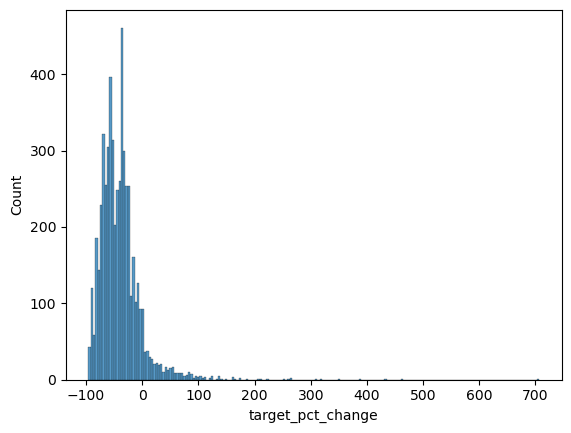

<Axes: xlabel='target_pct_change', ylabel='target_reference_mean'>

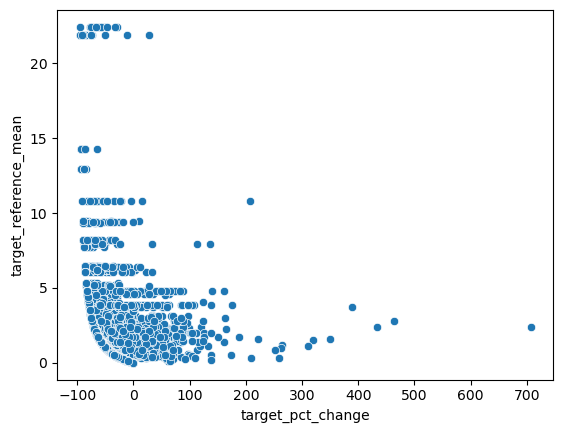

In [46]:
sns.histplot(adata.obs['target_pct_change'])
plt.show()

sns.scatterplot(x=adata.obs['target_pct_change'], y=adata.obs['target_reference_mean'])
plt.show()

/data_gilbert/home/awinters/bin/mambaforge/envs/scPy/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


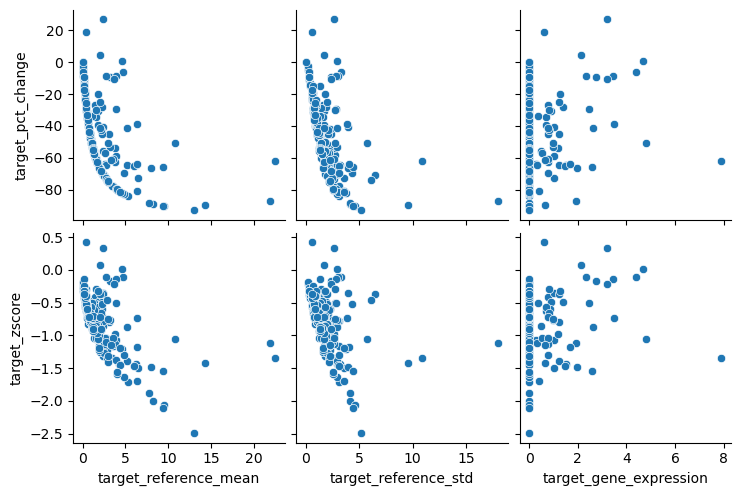

In [48]:
g = adata.obs.groupby('perturbation')[['target_reference_mean', 'target_reference_std', 'target_gene_expression', 'target_pct_change', 'target_zscore']].median()
sns.pairplot(g, y_vars=['target_pct_change', 'target_zscore'], x_vars=['target_reference_mean', 'target_reference_std', 'target_gene_expression'])
plt.show()

### Optional: Filter cells or perturbation classes based on target knockdown

In [50]:
## filter out cells that dont have at least 10% KD
adata = adata[adata.obs['target_pct_change'] < -10, :]

## Pseudobulk 

In [52]:
from pyturbseq.perturbseq import pseudobulk

In [53]:
pb = pseudobulk(
    adata,
    ['perturbation'],
    method='mean' #default and recommended method for pseudobulk
    )

Aggregating Samples:   0%|          | 0/232 [00:00<?, ?it/s]

Aggregating Samples: 100%|██████████| 232/232 [00:15<00:00, 14.65it/s]


In [56]:
pb

AnnData object with n_obs × n_vars = 232 × 36601
    obs: 'perturbation'
    var: 'gene_ids', 'feature_types'

In [ ]:
#for downstream analysis its recomomended to pseudobulk and all relevant covariates
# pb = pseudobulk(
#     adata,
#     ['treatment', 'perturbation', 'lane'],
#     method='mean' #default and recommended method for pseudobulk
#     )

# Analysis

### Differential Expression Analysis

Recommended to use pseudobulk
- https://www.nature.com/articles/s41467-021-25960-2
- 

In [60]:
from pyturbseq.de import get_all_degs_synchronously

In [59]:
degs = get_all_degs_synchronously(
    pb, 'perturbation', 'NTC',
    n_cpus=28,
    # max_workers=5,
    # quiet=False
    )

NameError: name 'get_all_degs_synchronously' is not defined

## Perturbation Similarity Analysis

### Pairwise similarity
